In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [19]:
# -------- ADD TO CELL 1 --------
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Add this after importing libraries

In [2]:
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
dataset_files = os.listdir(dataset_path)
print("✅ Dataset Structure:")
print(dataset_files)

✅ Dataset Structure:
['stage_2_train_images', 'stage_2_sample_submission.csv', 'stage_2_detailed_class_info.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_train_labels.csv', 'stage_2_test_images']


In [3]:
labels_path = os.path.join(dataset_path, "stage_2_train_labels.csv")
labels_df = pd.read_csv(labels_path)
print("✅ Labels Data Overview:")
display(labels_df.head())

print("\n✅ Dataset Stats:")
total_images = labels_df["patientId"].nunique()
pneumonia_cases = labels_df[labels_df["Target"] == 1].shape[0]
normal_cases = labels_df[labels_df["Target"] == 0].shape[0]

print(f"Total Unique Images: {total_images}")
print(f"Pneumonia Cases: {pneumonia_cases}")
print(f"Normal Cases: {normal_cases}")

✅ Labels Data Overview:


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1



✅ Dataset Stats:
Total Unique Images: 26684
Pneumonia Cases: 9555
Normal Cases: 20672


In [4]:
class_info_path = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")
class_info_df = pd.read_csv(class_info_path)
print("✅ Detailed Class Info Overview:")
display(class_info_df.head())

print("\n✅ Class Distribution:")
print(class_info_df['class'].value_counts())

✅ Detailed Class Info Overview:


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity



✅ Class Distribution:
class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


In [5]:
merged_df = pd.merge(labels_df, class_info_df, on='patientId')
print("✅ Merged Data Overview:")
display(merged_df.head())

print("\n✅ Cross-tabulation of Target and Class:")
print(pd.crosstab(merged_df['class'], merged_df['Target']))

✅ Merged Data Overview:


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity



✅ Cross-tabulation of Target and Class:
Target                            0      1
class                                     
Lung Opacity                      0  16957
No Lung Opacity / Not Normal  11821      0
Normal                         8851      0


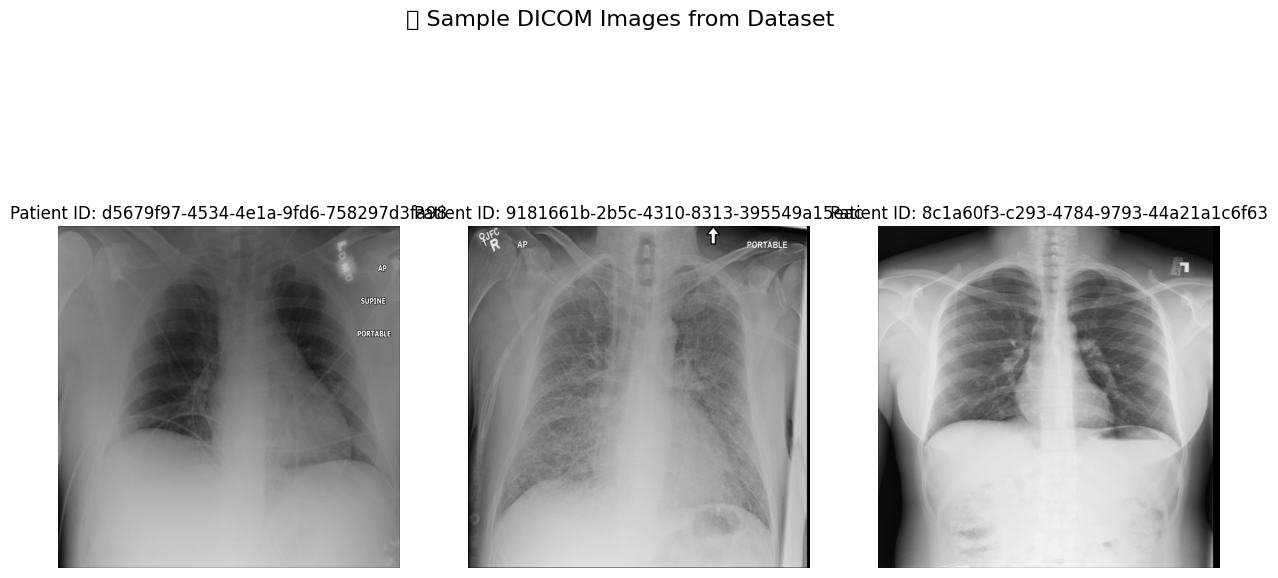

In [6]:
images_dir = os.path.join(dataset_path, "stage_2_train_images")
sample_images = merged_df.sample(3, random_state=42)['patientId'].values

fig, axes = plt.subplots(1, 3, figsize=(15, 8))
for i, patientId in enumerate(sample_images):
    image_path = os.path.join(images_dir, patientId + ".dcm")
    dicom_data = pydicom.dcmread(image_path)
    image = dicom_data.pixel_array
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Patient ID: {patientId}")
    axes[i].axis('off')

plt.suptitle("✅ Sample DICOM Images from Dataset", fontsize=16)
plt.show()

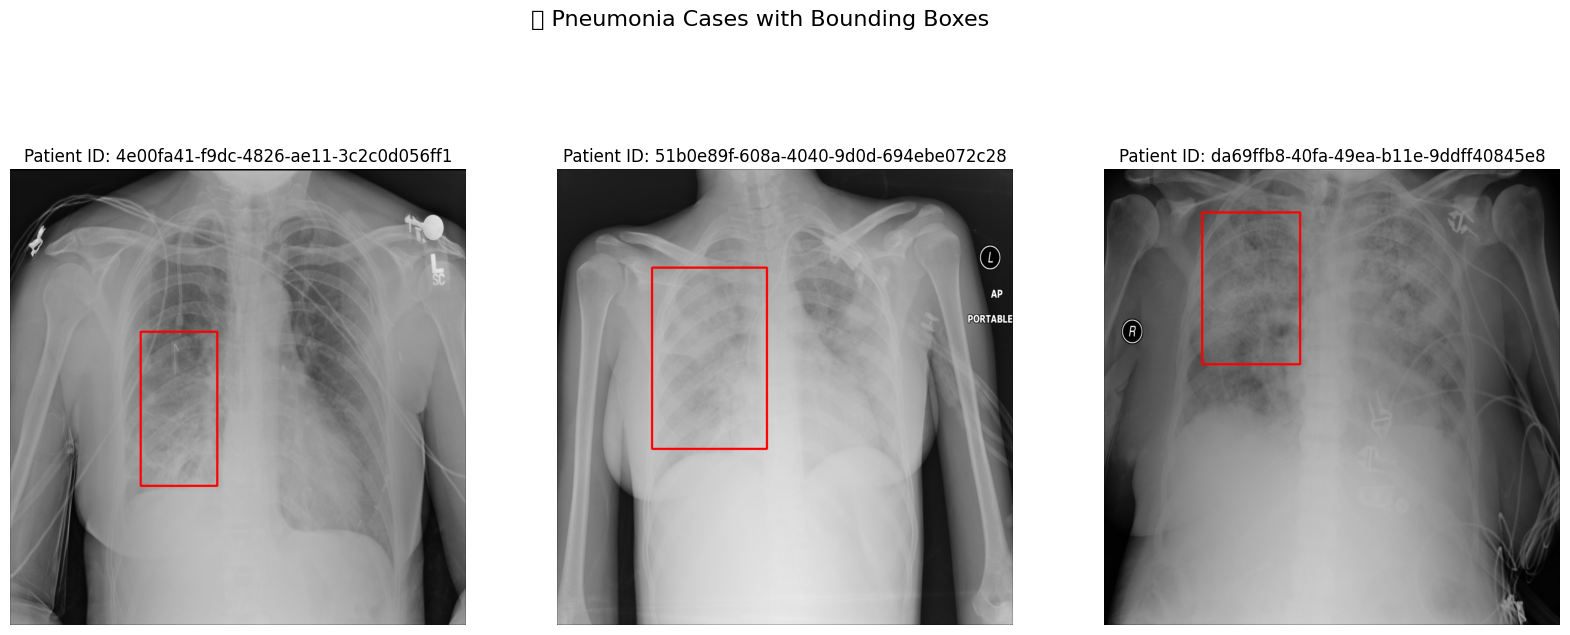

In [7]:
sample_pneumonia_cases = merged_df[merged_df['Target'] == 1].sample(3, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for i, row in enumerate(sample_pneumonia_cases.itertuples()):
    image_path = os.path.join(images_dir, row.patientId + ".dcm")
    dicom_data = pydicom.dcmread(image_path)
    image = dicom_data.pixel_array
    image_rgb = np.stack([image]*3, axis=-1)
    x, y, w, h = int(row.x), int(row.y), int(row.width), int(row.height)
    cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (255, 0, 0), 3)
    axes[i].imshow(image_rgb, cmap='gray')
    axes[i].set_title(f"Patient ID: {row.patientId}")
    axes[i].axis('off')

plt.suptitle("✅ Pneumonia Cases with Bounding Boxes", fontsize=16)
plt.show()

In [8]:
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple["patientId"] = labels_simple["patientId"].astype(str) + ".dcm"

print("✅ Simplified Labels DataFrame:")
display(labels_simple.head())
print(f"\nTotal labels: {labels_simple.shape[0]}")
print(labels_simple['Target'].value_counts())

✅ Simplified Labels DataFrame:


,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm,Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb.dcm,Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm,Normal
4,00436515-870c-4b36-a041-de91049b9ab4.dcm,Pneumonia



Total labels: 26684
Target
Normal       20672
Pneumonia     6012
Name: count, dtype: int64


In [9]:
# image_dir = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
# actual_files = os.listdir(image_dir)
# df_files = labels_simple['patientId'].tolist()

# matched = [f for f in df_files if f in actual_files]
# not_matched = [f for f in df_files if f not in actual_files]

# print(f"✅ Files matched: {len(matched)}")
# print(f"❌ Files NOT matched: {len(not_matched)}")

# if len(not_matched) > 0:
#     print("Examples of mismatched filenames:")
#     print(not_matched[:5])

✅ Files matched: 26684
❌ Files NOT matched: 0


In [11]:
# import tensorflow as tf
# import pydicom

# class DICOMDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, dataframe, base_dir, target_size=(224, 224), batch_size=32, subset='training', shuffle=True):
#         self.dataframe = dataframe
#         self.base_dir = base_dir
#         self.target_size = target_size
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.subset = subset
#         self.indices = self._split_indices()
#         self.on_epoch_end()

#     def _split_indices(self):
#         # Split into train/validation (80-20)
#         from sklearn.model_selection import train_test_split
#         indices = np.arange(len(self.dataframe))
#         train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=self.dataframe['Target'])
#         return train_idx if self.subset == 'training' else val_idx

#     def __len__(self):
#         return len(self.indices) // self.batch_size

#     def __getitem__(self, index):
#         batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
#         X = np.zeros((self.batch_size, *self.target_size, 3), dtype=np.float32)  # 3 channels for RGB
#         y = np.zeros((self.batch_size), dtype=np.int32)

#         for i, idx in enumerate(batch_indices):
#             row = self.dataframe.iloc[idx]
#             dicom_path = os.path.join(self.base_dir, row['patientId'])
#             dicom = pydicom.dcmread(dicom_path)
#             img = dicom.pixel_array.astype(np.float32)
            
#             # Resize, normalize, and convert to 3-channel
#             img = cv2.resize(img, self.target_size)
#             img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize to [0, 1]
#             img = np.stack([img] * 3, axis=-1)  # Convert grayscale to RGB
            
#             X[i] = img
#             y[i] = 1 if row['Target'] == 'Pneumonia' else 0  # Map labels to 0/1

#         return X, y

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indices)

# # Create generators
# train_gen = DICOMDataGenerator(labels_simple, image_dir, subset='training')
# val_gen = DICOMDataGenerator(labels_simple, image_dir, subset='validation')

# print("✅ Custom DICOM generators created!")
# print(f"Training batches: {len(train_gen)}")
# print(f"Validation batches: {len(val_gen)}")

✅ Custom DICOM generators created!
Training batches: 667
Validation batches: 166


In [13]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Define a simple CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Input shape matches generator's RGB output
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Binary classification (Pneumonia/Normal)
# ])

# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # Print model summary
# model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# history = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=10,
#     steps_per_epoch=len(train_gen),
#     validation_steps=len(val_gen)
# )

Epoch 1/10
638/667 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - accuracy: 0.7696 - loss: 0.5097

KeyboardInterrupt: 

# I replaced the code below from cell 9(replaced)  to use more optimized approach


cell 9

In [15]:
# -------- NEW CELL: PREPROCESS DICOM TO TFRECORDS --------
import tensorflow as tf

# Define paths
tfrecord_path = "/kaggle/working/preprocessed_data.tfrecords"

def create_tfrecords():
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for idx, row in labels_simple.iterrows():
            # Load DICOM
            dicom = pydicom.dcmread(os.path.join(image_dir, row['patientId']))
            img = dicom.pixel_array.astype(np.float32)
            
            # Preprocess (resize, normalize, RGB)
            img = cv2.resize(img, (128, 128))  # Reduce resolution for speed
            img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize [0,1]
            img = np.stack([img]*3, axis=-1)  # Convert to 3-channel
            
            # Serialize to TFRecord
            label = 1 if row['Target'] == 'Pneumonia' else 0
            example = tf.train.Example(features=tf.train.Features(feature={
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img.tobytes()])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }))
            writer.write(example.SerializeToString())

create_tfrecords()
print("✅ TFRecords created at:", tfrecord_path)

✅ TFRecords created at: /kaggle/working/preprocessed_data.tfrecords


In [16]:
# -------- NEW CELL: TF.DATA PIPELINE --------
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    image = tf.reshape(image, (128, 128, 3))  # Match preprocessing shape
    return image, example['label']

# Create dataset
dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

# Split into train/validation
train_size = int(0.8 * len(labels_simple))
train_data = dataset.take(train_size)
val_data = dataset.skip(train_size)

print("✅ Optimized dataset pipeline created!")

✅ Optimized dataset pipeline created!


In [17]:
# -------- MODIFIED CELL 11: SIMPLER MODEL --------
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    GlobalAveragePooling2D(),  # Replaces Flatten + Dense
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# -------- MODIFIED CELL 12: TRAINING --------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7456 - loss: 0.5614
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7465 - loss: 0.5589
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7486 - loss: 0.5570
Epoch 4/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7466 - loss: 0.5598
Epoch 5/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7482 - loss: 0.5579
Epoch 6/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7473 - loss: 0.5590
Epoch 7/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7463 - loss: 0.5599
Epoch 8/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7479 - loss: 0.5578
Epoch 9/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7480 - loss: 0.5571
Epoch 10/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7472 - loss: 0.5583


# ouputs show that model is learning but baised due to class imbalcne  

# now we will handle class imbalance and train again

In [22]:
# -------- NEW CELL 13: CLASS WEIGHTS --------
# Calculate class weights to handle imbalance
normal_count = labels_simple['Target'].value_counts()['Normal']
pneumonia_count = labels_simple['Target'].value_counts()['Pneumonia']
total = normal_count + pneumonia_count

class_weights = {
    0: (1 / normal_count) * (total / 2),  # Weight for "Normal"
    1: (1 / pneumonia_count) * (total / 2)  # Weight for "Pneumonia"
}

print("Class weights:", class_weights)

Class weights: {0: 0.6454140866873065, 1: 2.2192282102461744}


In [23]:
# -------- NEW CELL 14: TRANSFER LEARNING MODEL --------
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

# Load pre-trained base model
base_model = EfficientNetB0(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False  # Exclude the top classification layer
)
base_model.trainable = False  # Freeze layers

# Build new model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with AUC and Recall metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),  # Track AUC
        tf.keras.metrics.Recall(name='recall')  # Track sensitivity
    ]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [24]:
# -------- NEW CELL 15: DATA AUGMENTATION --------
def augment_data(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Apply augmentation to training data
train_data_augmented = train_data.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
# -------- NEW CELL 16: RETRAIN WITH IMPROVEMENTS --------
history = model.fit(
    train_data_augmented,
    validation_data=val_data,
    epochs=20,  # Train longer
    class_weight=class_weights  # From Cell 13
)

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.5686 - auc: 0.5808 - loss: 0.7091 - recall: 0.5864
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.3279 - auc: 0.4715 - loss: 0.7242 - recall: 0.8608
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4134 - auc: 0.4736 - loss: 0.7242 - recall: 0.6517
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.3119 - auc: 0.4771 - loss: 0.7222 - recall: 0.8862
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4027 - auc: 0.4687 - loss: 0.7230 - recall: 0.6662
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4398 - auc: 0.4641 - loss: 0.7254 - recall: 0.5657
Epoch 7/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4712 - auc: 0.4702 - loss: 0.7222 - recall: 0.4894
Epoch 8/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.4754 - auc: 0.4725 - loss: 0.7248 - recall: 0.4903
Epoch 9/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms

# The model is failing to learn meaningful patterns from the data, as evidenced by the stagnant AUC (~0.47) and erratic recall.

Why It's Bad: EfficientNetB0 layers are frozen, so the model cannot adapt to X-ray features.

# 1. ✅ Good Till now

In [26]:
# -------- NEW CELL 17: UNFREEZE BASE MODEL --------
# Unfreeze all layers
base_model.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc', 'recall']
)

print("✅ Base model unfrozen and recompiled!")

✅ Base model unfrozen and recompiled!


In [27]:
# -------- NEW CELL 18: RETRAIN WITH FIXES --------
history = model.fit(
    train_data_augmented,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights,
    verbose=2
)

Epoch 1/10
417/417 - 167s - 400ms/step - accuracy: 0.5423 - auc: 0.6454 - loss: 0.7365 - recall: 0.7399
Epoch 2/10
417/417 - 31s - 73ms/step - accuracy: 0.6695 - auc: 0.7593 - loss: 0.6082 - recall: 0.7553
Epoch 3/10
417/417 - 30s - 73ms/step - accuracy: 0.6887 - auc: 0.7876 - loss: 0.5693 - recall: 0.7796
Epoch 4/10
417/417 - 30s - 73ms/step - accuracy: 0.7015 - auc: 0.8024 - loss: 0.5521 - recall: 0.7863
Epoch 5/10
417/417 - 30s - 72ms/step - accuracy: 0.7124 - auc: 0.8167 - loss: 0.5301 - recall: 0.7974
Epoch 6/10
417/417 - 30s - 73ms/step - accuracy: 0.7238 - auc: 0.8307 - loss: 0.5090 - recall: 0.8137
Epoch 7/10
417/417 - 31s - 73ms/step - accuracy: 0.7280 - auc: 0.8343 - loss: 0.5028 - recall: 0.8094
Epoch 8/10
417/417 - 30s - 73ms/step - accuracy: 0.7340 - auc: 0.8424 - loss: 0.4901 - recall: 0.8164
Epoch 9/10
417/417 - 30s - 73ms/step - accuracy: 0.7389 - auc: 0.8490 - loss: 0.4805 - recall: 0.8159
Epoch 10/10
417/417 - 30s - 73ms/step - accuracy: 0.7440 - auc: 0.8537 - loss: 0

In [31]:
# -------- FIXED CODE FOR DATASET SPLITTING --------
# Load the full dataset
full_dataset = tf.data.TFRecordDataset(tfrecord_path)
full_dataset = full_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

# Total number of samples (from your labels_simple DataFrame)
num_samples = len(labels_simple)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

# Batch size (defined earlier as 64)
batch_size = 64

# Calculate number of batches
num_train_batches = train_size // batch_size
num_val_batches = val_size // batch_size

# Split into train/validation
train_data = full_dataset.take(train_size).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = full_dataset.skip(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"✅ Train batches: ~{num_train_batches}, Val batches: ~{num_val_batches}")

✅ Train batches: ~333, Val batches: ~83


In [32]:
# Test evaluation
val_loss, val_acc, val_auc, val_recall = model.evaluate(val_data, verbose=0)
print(f"Validation AUC: {val_auc:.3f}")

Validation AUC: 0.887


In [33]:
model.save("/kaggle/working/pneumonia_detection_model.keras")
print("✅ Model saved!")

✅ Model saved!


# Congrats the prev model have Validation AUC: 0.887